Before SMOTE:
Class distribution: Counter({np.int64(0): 14497, np.int64(1): 923})
After SMOTE:
Class distribution: Counter({np.int64(0): 14497, np.int64(1): 14497})
Epoch 1/50
725/725 ━━━━━━━━━━━━━━━━━━━━ 2s 872us/step - loss: 2427461.2500 - val_loss: 2379995.0000
Epoch 2/50
725/725 ━━━━━━━━━━━━━━━━━━━━ 1s 745us/step - loss: 2400381.0000 - val_loss: 2379995.0000
Epoch 3/50
725/725 ━━━━━━━━━━━━━━━━━━━━ 1s 748us/step - loss: 2428009.0000 - val_loss: 2379995.0000
Epoch 4/50
725/725 ━━━━━━━━━━━━━━━━━━━━ 1s 734us/step - loss: 2393901.7500 - val_loss: 2379995.0000
Epoch 5/50
725/725 ━━━━━━━━━━━━━━━━━━━━ 1s 724us/step - loss: 2400720.5000 - val_loss: 2379995.0000
Epoch 6/50
725/725 ━━━━━━━━━━━━━━━━━━━━ 1s 730us/step - loss: 2387963.0000 - val_loss: 2379995.0000
Epoch 7/50
725/725 ━━━━━━━━━━━━━━━━━━━━ 1s 729us/step - loss: 2389664.0000 - val_loss: 2379995.0000
Epoch 8/50
725/725 ━━━━━━━━━━━━━━━━━━━━ 1s 750us/step - loss: 2396987.2500 - val_loss: 2379995.0000
Epoch 9/50
725/725 ━━━━━━━━━━━━━━━━

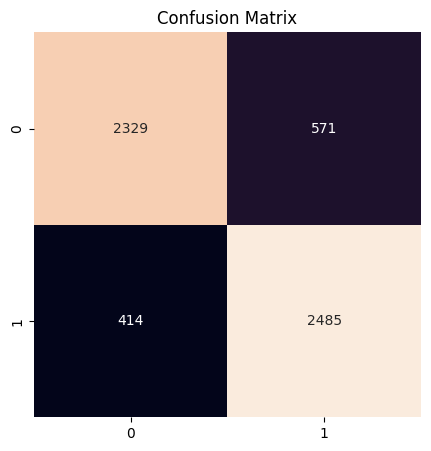

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

from collections import Counter
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import shuffle
from imblearn.over_sampling import SMOTE

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
import warnings

warnings.filterwarnings("ignore")

# Load dataset
path = r'C:\Users\Admin\Downloads\carclaims.csv'
df = pd.read_csv(path)

# Encode target variable
df.loc[df['FraudFound'] == 'No', 'FraudFound'] = 0
df.loc[df['FraudFound'] == 'Yes', 'FraudFound'] = 1
df['FraudFound'] = df['FraudFound'].astype(int)

# Label encode categorical features
le = LabelEncoder()
cols = df.select_dtypes('O').columns
df[cols] = df[cols].apply(le.fit_transform)
df['Year'] = le.fit_transform(df.Year)

# Define features and target
X = df.drop('FraudFound', axis=1).values
y = df['FraudFound'].values

# Apply SMOTE to balance the dataset
smote = SMOTE(random_state=42)
X_smote, y_smote = smote.fit_resample(X, y)

print("Before SMOTE:")
print(f"Class distribution: {Counter(y)}")
print("After SMOTE:")
print(f"Class distribution: {Counter(y_smote)}")

# Shuffle SMOTE-generated data
X_smote, y_smote = shuffle(X_smote, y_smote, random_state=42)

# Define Autoencoder
input_dim = X_smote.shape[1]
encoding_dim = 16  # Latent space dimension

# Encoder
input_layer = Input(shape=(input_dim,))
encoded = Dense(64, activation='relu')(input_layer)
encoded = Dense(32, activation='relu')(encoded)
latent = Dense(encoding_dim, activation='relu')(encoded)

# Decoder
decoded = Dense(32, activation='relu')(latent)
decoded = Dense(64, activation='relu')(decoded)
output_layer = Dense(input_dim, activation='sigmoid')(decoded)

# Autoencoder model
autoencoder = Model(inputs=input_layer, outputs=output_layer)
autoencoder.compile(optimizer='adam', loss='mse')

# Train autoencoder on SMOTE data
autoencoder.fit(X_smote, X_smote, epochs=50, batch_size=32, shuffle=True, validation_split=0.2)

# Extract latent representations
encoder = Model(inputs=autoencoder.input, outputs=latent)
X_latent = encoder.predict(X_smote)

# Split latent data into training and testing sets
X_train_latent, X_test_latent, y_train_latent, y_test_latent = train_test_split(
    X_latent, y_smote, test_size=0.2, stratify=y_smote, random_state=42
)

# Train Random Forest Classifier on Latent Space
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train_latent, y_train_latent)

# Make predictions
y_pred_latent = clf.predict(X_test_latent)

# Evaluate the model
accuracy = accuracy_score(y_test_latent, y_pred_latent)
precision = precision_score(y_test_latent, y_pred_latent)
recall = recall_score(y_test_latent, y_pred_latent)
f1 = f1_score(y_test_latent, y_pred_latent)

print("\n=== Random Forest on SMOTE + Autoencoder Processed Data ===")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Confusion Matrix
def conf_matrix(y_test, y_pred):
    con_matrix = confusion_matrix(y_test, y_pred)
    con_matrix = pd.DataFrame(con_matrix, range(2), range(2))
    plt.figure(figsize=(5, 5))
    plt.title("Confusion Matrix")
    sns.heatmap(con_matrix, annot=True, cbar=False, fmt='g')

conf_matrix(y_test_latent, y_pred_latent)


Before SMOTE:
Class distribution: Counter({np.int64(0): 14497, np.int64(1): 923})
After SMOTE:
Class distribution: Counter({np.int64(0): 14497, np.int64(1): 14497})
Epoch 1/50
725/725 ━━━━━━━━━━━━━━━━━━━━ 2s 870us/step - loss: 2423974.2500 - val_loss: 2379995.0000
Epoch 2/50
725/725 ━━━━━━━━━━━━━━━━━━━━ 1s 735us/step - loss: 2392809.7500 - val_loss: 2379994.7500
Epoch 3/50
725/725 ━━━━━━━━━━━━━━━━━━━━ 1s 739us/step - loss: 2382130.0000 - val_loss: 2379994.7500
Epoch 4/50
725/725 ━━━━━━━━━━━━━━━━━━━━ 1s 745us/step - loss: 2397810.7500 - val_loss: 2379994.7500
Epoch 5/50
725/725 ━━━━━━━━━━━━━━━━━━━━ 1s 750us/step - loss: 2387666.0000 - val_loss: 2379994.7500
Epoch 6/50
725/725 ━━━━━━━━━━━━━━━━━━━━ 1s 736us/step - loss: 2401415.0000 - val_loss: 2379994.7500
Epoch 7/50
725/725 ━━━━━━━━━━━━━━━━━━━━ 1s 732us/step - loss: 2402485.7500 - val_loss: 2379994.7500
Epoch 8/50
725/725 ━━━━━━━━━━━━━━━━━━━━ 1s 733us/step - loss: 2415771.7500 - val_loss: 2379994.7500
Epoch 9/50
725/725 ━━━━━━━━━━━━━━━━

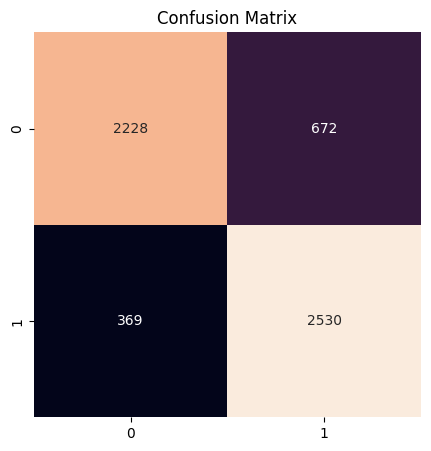

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from collections import Counter
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, accuracy_score
from imblearn.over_sampling import SMOTE
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from sklearn.utils import shuffle
from xgboost import XGBClassifier
import warnings
warnings.filterwarnings("ignore")

# Load dataset
path = r'C:\Users\Admin\Downloads\carclaims.csv'
df = pd.read_csv(path)

# Encode target variable
df.loc[df['FraudFound'] == 'No', 'FraudFound'] = 0
df.loc[df['FraudFound'] == 'Yes', 'FraudFound'] = 1
df['FraudFound'] = df['FraudFound'].astype(int)

# Label encode categorical features
le = LabelEncoder()
cols = df.select_dtypes('O').columns
df[cols] = df[cols].apply(le.fit_transform)
df['Year'] = le.fit_transform(df.Year)

# Define features and target
X = df.drop('FraudFound', axis=1).values
y = df['FraudFound'].values

# Apply SMOTE to balance the dataset
smote = SMOTE(random_state=42)
X_smote, y_smote = smote.fit_resample(X, y)

print("Before SMOTE:")
print(f"Class distribution: {Counter(y)}")
print("After SMOTE:")
print(f"Class distribution: {Counter(y_smote)}")

# Shuffle SMOTE-generated data
X_smote, y_smote = shuffle(X_smote, y_smote, random_state=42)

# Define Autoencoder
input_dim = X_smote.shape[1]
encoding_dim = 16  # Latent space dimension

# Encoder
input_layer = Input(shape=(input_dim,))
encoded = Dense(64, activation='relu')(input_layer)
encoded = Dense(32, activation='relu')(encoded)
latent = Dense(encoding_dim, activation='relu')(encoded)

# Decoder
decoded = Dense(32, activation='relu')(latent)
decoded = Dense(64, activation='relu')(decoded)
output_layer = Dense(input_dim, activation='sigmoid')(decoded)

# Autoencoder model
autoencoder = Model(inputs=input_layer, outputs=output_layer)
autoencoder.compile(optimizer='adam', loss='mse')

# Train autoencoder on SMOTE data
autoencoder.fit(X_smote, X_smote, epochs=50, batch_size=32, shuffle=True, validation_split=0.2)

# Extract latent representations
encoder = Model(inputs=autoencoder.input, outputs=latent)
X_latent = encoder.predict(X_smote)

# Split latent data into training and testing sets
X_train_latent, X_test_latent, y_train_latent, y_test_latent = train_test_split(
    X_latent, y_smote, test_size=0.2, stratify=y_smote, random_state=42
)

# Train XGBoost Classifier on Latent Space
xgb_clf = XGBClassifier(
    use_label_encoder=False,  # Disable the deprecation warning
    eval_metric='logloss',   # Set evaluation metric
    random_state=42
)
xgb_clf.fit(X_train_latent, y_train_latent)

# Make predictions
y_pred_latent = xgb_clf.predict(X_test_latent)

# Evaluate the model
accuracy = accuracy_score(y_test_latent, y_pred_latent)
precision = precision_score(y_test_latent, y_pred_latent)
recall = recall_score(y_test_latent, y_pred_latent)
f1 = f1_score(y_test_latent, y_pred_latent)

print("\n=== XGBoost on SMOTE + Autoencoder Processed Data ===")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Confusion Matrix
def conf_matrix(y_test, y_pred):
    con_matrix = confusion_matrix(y_test, y_pred)
    con_matrix = pd.DataFrame(con_matrix, range(2), range(2))
    plt.figure(figsize=(5, 5))
    plt.title("Confusion Matrix")
    sns.heatmap(con_matrix, annot=True, cbar=False, fmt='g')

conf_matrix(y_test_latent, y_pred_latent)


Before Balancing:
Training Class distribution: Counter({np.int64(0): 11598, np.int64(1): 738})
Testing Class distribution: Counter({np.int64(0): 2899, np.int64(1): 185})

After SMOTE:
Training Class distribution: Counter({np.int64(0): 11598, np.int64(1): 11598})
Epoch 1/50
580/580 ━━━━━━━━━━━━━━━━━━━━ 2s 933us/step - loss: 2411543.0000 - val_loss: 2351414.2500
Epoch 2/50
580/580 ━━━━━━━━━━━━━━━━━━━━ 0s 737us/step - loss: 2398519.2500 - val_loss: 2351414.2500
Epoch 3/50
580/580 ━━━━━━━━━━━━━━━━━━━━ 0s 741us/step - loss: 2400965.0000 - val_loss: 2351414.7500
Epoch 4/50
580/580 ━━━━━━━━━━━━━━━━━━━━ 0s 773us/step - loss: 2406391.2500 - val_loss: 2351414.7500
Epoch 5/50
580/580 ━━━━━━━━━━━━━━━━━━━━ 0s 739us/step - loss: 2419697.0000 - val_loss: 2351414.7500
Epoch 6/50
580/580 ━━━━━━━━━━━━━━━━━━━━ 0s 739us/step - loss: 2363665.7500 - val_loss: 2351414.7500
Epoch 7/50
580/580 ━━━━━━━━━━━━━━━━━━━━ 0s 727us/step - loss: 2405084.5000 - val_loss: 2351414.7500
Epoch 8/50
580/580 ━━━━━━━━━━━━━━━━━━

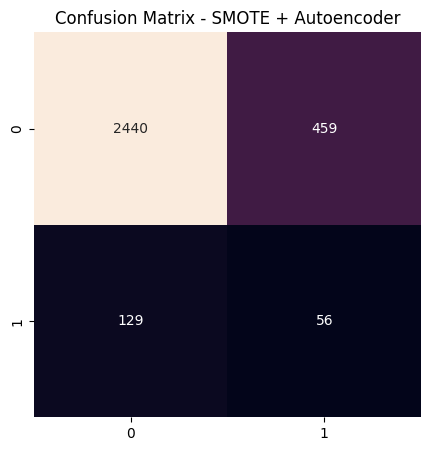

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

from collections import Counter
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import shuffle
from imblearn.over_sampling import SMOTE

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
import warnings

warnings.filterwarnings("ignore")

# Load dataset
path = r'C:\Users\Admin\Downloads\carclaims.csv'
df = pd.read_csv(path)

# Encode target variable
df.loc[df['FraudFound'] == 'No', 'FraudFound'] = 0
df.loc[df['FraudFound'] == 'Yes', 'FraudFound'] = 1
df['FraudFound'] = df['FraudFound'].astype(int)

# Label encode categorical features
le = LabelEncoder()
cols = df.select_dtypes('O').columns
df[cols] = df[cols].apply(le.fit_transform)
df['Year'] = le.fit_transform(df.Year)

# Define features and target
X = df.drop('FraudFound', axis=1).values
y = df['FraudFound'].values

# Split the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print("Before Balancing:")
print(f"Training Class distribution: {Counter(y_train)}")
print(f"Testing Class distribution: {Counter(y_test)}")

# Apply SMOTE to the training set only
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

print("\nAfter SMOTE:")
print(f"Training Class distribution: {Counter(y_train_smote)}")

# Shuffle the SMOTE-balanced data
X_train_smote, y_train_smote = shuffle(X_train_smote, y_train_smote, random_state=42)

# Define Autoencoder
input_dim = X_train_smote.shape[1]
encoding_dim = 16  # Latent space dimension

# Encoder
input_layer = Input(shape=(input_dim,))
encoded = Dense(64, activation='relu')(input_layer)
encoded = Dense(32, activation='relu')(encoded)
latent = Dense(encoding_dim, activation='relu')(encoded)

# Decoder
decoded = Dense(32, activation='relu')(latent)
decoded = Dense(64, activation='relu')(decoded)
output_layer = Dense(input_dim, activation='sigmoid')(decoded)

# Autoencoder model
autoencoder = Model(inputs=input_layer, outputs=output_layer)
autoencoder.compile(optimizer='adam', loss='mse')

# Train autoencoder on SMOTE-balanced training data
autoencoder.fit(X_train_smote, X_train_smote, epochs=50, batch_size=32, shuffle=True, validation_split=0.2)

# Extract latent representations
encoder = Model(inputs=autoencoder.input, outputs=latent)
X_train_latent = encoder.predict(X_train_smote)
X_test_latent = encoder.predict(X_test)  # Apply the same transformation to the test set

# Train Random Forest Classifier on Latent Space
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train_latent, y_train_smote)

# Make predictions
y_pred_latent = clf.predict(X_test_latent)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred_latent)
precision = precision_score(y_test, y_pred_latent)
recall = recall_score(y_test, y_pred_latent)
f1 = f1_score(y_test, y_pred_latent)

print("\n=== Random Forest on SMOTE + Autoencoder Processed Data ===")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Confusion Matrix
def conf_matrix(y_test, y_pred, title):
    con_matrix = confusion_matrix(y_test, y_pred)
    con_matrix = pd.DataFrame(con_matrix, range(2), range(2))
    plt.figure(figsize=(5, 5))
    plt.title(title)
    sns.heatmap(con_matrix, annot=True, cbar=False, fmt='g')
    plt.show()

conf_matrix(y_test, y_pred_latent, "Confusion Matrix - SMOTE + Autoencoder")
